In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt

/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_train.csv
/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_sample.csv
/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_test.csv


In [2]:
Data_Train = pd.read_csv('/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_train.csv')

In [3]:
#читаем трейн
def read_train(path_to_csv):
    Data = pd.read_csv(path_to_csv)
    Data_X = Data.iloc[:, 1:]
    Data_Y = Data.iloc[:, 0:1]
    Data_X = replace_nans(Data_X)
    
    NData_X = Data_X.to_numpy()
    NData_Y = Data_Y.to_numpy()
    
    return(NData_X, NData_Y)
#читаем тест
def read_test(path_to_csv):
    Data = pd.read_csv(path_to_csv)
    Data_X = Data.drop(['Id'], axis = 1)
    Data_X = replace_nans(Data_X)
    NData_X = Data_X.to_numpy()
    return(NData_X)
#осталось с логистической регрессии
def normalize(X):
    H = X * np.sign(X)
    NormMax = np.amax(H, axis = 0)
    X = X / NormMax
    return (X, NormMax)
#убираем наны
def replace_nans(X):
    if np.all(np.isnan(X)):
      X[:] = 0
      return X
    else:
      X[np.isnan(X)] = 0
      return X

In [4]:
def logloss(y, pred):
    ans = -y * np.log(pred) - (1 - y) * np.log(1 - pred)
    return np.mean(ans)

#рисуем ROC и считаем AUC
def AUC_ROC(y, pred, draw = False):
    values = np.unique(pred)
    values = np.sort(-1 * values)
    values = -1 * values
    
    TP = [0 for i in range(len(values))]
    FP = [0 for i in range(len(values))]
    FN = [0 for i in range(len(values))]
    TN = [0 for i in range(len(values))]
    
    TPR = []
    FPR = []
    
    TPR.append(0)
    FPR.append(0)
    
    for thresh_i in range(len(values)):
        TP[thresh_i] = np.sum(y * [pred >= values[thresh_i]])
        FP[thresh_i] = np.sum((1 - y) * [pred >= values[thresh_i]])
        FN[thresh_i] = np.sum(y * [pred < values[thresh_i]])
        TN[thresh_i] = np.sum((1 - y) * [pred < values[thresh_i]])
        
        TPR.append(TP[thresh_i] / (TP[thresh_i] + FN[thresh_i]))
        FPR.append(FP[thresh_i] / (FP[thresh_i] + TN[thresh_i]))
        
    if (draw == True):
        plt.plot(FPR, TPR, color = 'green')
        plt.plot([0, 1], [0, 1], color = 'red')
        plt.show()
    
    AUC = 0
    
    TPR = np.array(TPR)
    FPR = np.array(FPR)
    
    AUC = 0
    for thresh_i in range(len(values)):
        AUC += (TPR[thresh_i + 1] - TPR[thresh_i])*(FPR[thresh_i + 1] + FPR[thresh_i])/2
    return 1 - AUC

#кросс-валидация 
def cross_validation(X, Y, classifier, cls_args, tree_args, k = 5, amount_of_attepmts = 1):
    res = []
    
    for i in range(amount_of_attepmts):
        test_indices = np.random.randint(k, size = len(X))
        for j in range(k):
            X_train = X[test_indices != j]
            X_test = X[test_indices == j]
            Y_train = Y[test_indices != j]
            Y_test = Y[test_indices == j]
            
            cls = classifier(**cls_args)
            cls.build_tree(X_train, Y_train, **tree_args)
            
            ans = cls.predict(X_test)
            
            res.append(AUC_ROC(Y_test, ans))
    print(f"AUC = {np.mean(res):.4f}±{np.std(res):.4f}")

In [5]:
#на самом деле просто энтропия, просто мне стало лень везде исправлять названия
def cross_entropy(x):
    p = np.unique(x, return_counts=True)[1] / len(x)
    return -p@np.log2(p)
#индекс Джини
def gini(x):
    p = np.unique(x, return_counts=True)[1] / len(x)
    return p@(1 - p)
#impurity function
def impurity_score(U_left, U_right, L):
    U = np.concatenate((U_left, U_right))
    Phi = L(U)
    Phi_left = L(U_left)
    Phi_right = L(U_right)
    
    len_l, len_r = len(U_left), len(U_right)
    len_whole = len_l + len_r
    return len_whole * Phi - len_l * Phi_left - len_r * Phi_right

In [6]:
#один лист дерева
class DTree_Leaf:
    def __init__(self, estimates, size):
        self.estimates = estimates
        self.size = size
        self.y = max(estimates, key=estimates.get)

#вершина, не лист дерева        
class DTree_DNode:
    def __init__(self, feature, split_value, left, right):
        self.feature = feature
        self.split_value = split_value
        self.left = left
        self.right = right

In [7]:
#класс самого дерева (для произвольного количества классов)
class DTree_classifier():
    def __init__(self, imp_func="gini", max_depth=None, min_size_leaf=1):
        self.max_depth = max_depth
        self.min_size_leaf = min_size_leaf
        if imp_func == "gini":
            self.imp_func = gini
        elif imp_func == "entr":
            self.imp_func = cross_entropy
        else:
            raise ValueError(f"wrong impurity function {imp_func}")
    
    def build_node(self, X, Y, indices, depth, strings_features_positions):
        def build_leaf():
            est = dict(zip(np.unique(Y), np.zeros(len(np.unique(Y)))))
            cur_classes, cur_counters = np.unique(Y[indices], return_counts = True)
            cur_est = dict(zip(cur_classes, cur_counters / len(indices)))
            est.update(cur_est)
            return DTree_Leaf(est, len(indices))
        
        if ((self.max_depth is not None and depth >= self.max_depth) or len(np.unique(Y[indices])) == 1 or len(indices) < 2 * self.min_size_leaf):
            return build_leaf()
        
        best_score = None
        best_U_1 = None
        best_U_2 = None
        best_feature = None
        best_value = None
        
        for feature in range(X.shape[1]):
            cur_sorted_indices = np.zeros(X.shape[0], dtype = int) - 1
            cur_sorted_indices[strings_features_positions[indices, feature]] = indices
            cur_sorted_indices = cur_sorted_indices[cur_sorted_indices >= 0]
            
            for v in range(len(cur_sorted_indices)):
                cur_U_1 = cur_sorted_indices[:v + 1]
                cur_U_2 = cur_sorted_indices[v + 1:]
                if ((len(cur_U_1) >= self.min_size_leaf and len(cur_U_2) >= self.min_size_leaf) or (len(cur_U_1) == 0) or (len(cur_U_2) == 0)):
                    temp_score = impurity_score(Y[cur_U_1], Y[cur_U_2], self.imp_func)
                    if (best_score == None or temp_score > best_score):
                        best_score = temp_score
                        best_U_1 = cur_U_1
                        best_U_2 = cur_U_2
                        best_feature = feature
                        best_value = X[cur_sorted_indices[v], feature]
        if (len(best_U_1) == 0 or len(best_U_2) == 0):
            return build_leaf()
        left_node = self.build_node(X, Y, best_U_1, depth + 1, strings_features_positions)
        right_node = self.build_node(X, Y, best_U_2, depth + 1, strings_features_positions)
        cur_node = DTree_DNode(best_feature, best_value, left_node, right_node)
        return cur_node
    
    def build_tree(self, X, Y):
        strings_features_positions = np.zeros(np.shape(X), dtype = int)
        for i in range(X.shape[1]):
            strings_features_positions[np.argsort(X[:, i]), i] = np.arange(np.shape(X)[0])
        start_indices = np.arange(np.shape(X)[0], dtype = int)
        self.root = self.build_node(X, Y, start_indices, 0, strings_features_positions)
    
    def estimate_one_point(self, x_test_string, show_path = False):
        node = self.root
        path = []
        
        while not isinstance(node, DTree_Leaf):
            if (x_test_string[node.feature] <= node.split_value):
                node = node.left
                if (show_path == True):
                    path.append((node.feature, node.split_value, x_test_string[node.feature], 'left'))
            else:
                node = node.right
                if (show_path == True):
                    path.append((node.feature, node.split_value, x_test_string[node.feature], 'right'))
        if (show_path == True):
            return (node.estimates, path)
        else:
            return node.estimates
    
    def predict(self, X_test, show_path = False):
        ans = []
        paths = []
        
        for s in range(np.shape(X_test)[0]):
            cur_est = self.estimate_one_point(X_test[s, :])
            if (show_path == True):
                paths.append(self.estimate_one_point(X_test[s, :], True)[1])
            if len(cur_est.keys()) == 2:
                ans.append(cur_est[1])
            else:
                ans.append(max(cur_est.keys(), key = lambda k: cur_est[k]))
        ans = np.array(ans).reshape(-1, 1)
        
        if (show_path == True):
            return (ans, paths)
        else:
            return ans

In [8]:
(X_Train, Y_Train) = read_train('/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_train.csv')
X_Test = read_test('/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_test.csv')

In [9]:
cross_validation(X_Train, Y_Train, DTree_classifier, {"imp_func": "entr", "max_depth": 5, "min_size_leaf": 20}, {})

AUC = 0.9238±0.0100


In [10]:
#лучшая попытка
Third_attempt = DTree_classifier('entr', 5, 20)
Third_attempt.build_tree(X_Train, Y_Train)

X_Test = read_test('/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_test.csv')
Test_Data = pd.read_csv('/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_test.csv')

In [11]:
Ans = Third_attempt.predict(X_Test)
Ans.mean(), Y_Train.mean()

(0.5712518710895785, 0.555)

In [12]:
Ans_Train = Third_attempt.predict(X_Train)
AUC_ROC(Y_Train, Ans_Train)

0.9678692175321388

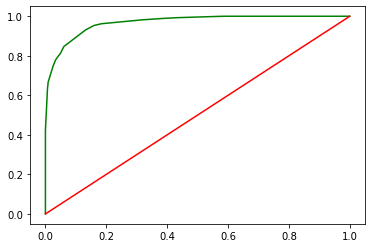

0.9678692175321388

In [13]:
AUC_ROC(Y_Train, Ans_Train, True)

In [14]:
#сабмит лучшей попытки
submission = pd.DataFrame()
submission['Id'] = Test_Data.index
submission['target'] = Ans
submission = submission[['target', 'Id']]
submission.to_csv('submission_fourth_test.csv', index=False)

In [15]:
#еще я последней попыткой попробовал квадраты фич поставить, но только потом понял, что это почти то же самое
X_Train_sq = np.hstack((X_Train, X_Train**2))
cross_validation(X_Train_sq, Y_Train, DTree_classifier, {"imp_func": "entr", "max_depth": 5, "min_size_leaf": 20}, {}, 5, 1)


AUC = 0.9206±0.0208


In [16]:
#последняя попытка с квадратами фич
Forth_attempt = DTree_classifier('entr', 6, 15)
Forth_attempt.build_tree(X_Train_sq, Y_Train)

X_Test = read_test('/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_test.csv')
Test_Data = pd.read_csv('/kaggle/input/mkn-ml-2020-competition-1-true-part-2/comp2_test.csv')
X_Test_sq = np.hstack((X_Test, X_Test**2))


In [17]:
Ans = Forth_attempt.predict(X_Test_sq)
Ans.mean(), Y_Train.mean()

(0.5655255295434135, 0.555)

In [18]:
Ans_Train = Forth_attempt.predict(X_Train_sq)
AUC_ROC(Y_Train, Ans_Train)

0.9753173398117219

In [19]:
#сабмит последней попытки
submission = pd.DataFrame()
submission['Id'] = Test_Data.index
submission['target'] = Ans
submission = submission[['target', 'Id']]
submission.to_csv('submission_fifth_test.csv', index=False)